## Ground Truth Generation Notebook.

This notebook generates a pre configured number of molecules and shows their alignments

In [53]:
Molecule = 2 #Pick molecule Number between 0 and 512

### Imports 

In [54]:
%load_ext autoreload
%autoreload 2

import numpy
from scipy.interpolate import interp1d
from deepom.bionano_utils import MoleculeSelector

from deepom.config import Config
from deepom.localizer import LocalizerModule
import monai

from deepom.aligner import Aligner
from deepom.my_utils import get_aligner, overlap_percentage, get_scaler_from_aligner
import numpy as np

from deepom.bionano_compare import BionanoCompare
from matplotlib.pyplot import eventplot, imshow, figure, xlim




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### selector Creation

In [55]:
#Need To check about Caching
selector = MoleculeSelector()
selector.top_mol_num = 50
selector.select_molecules()

selected: 0it [00:00, ?it/s]

### Refs

In [56]:
compare = BionanoCompare()
compare.read_cmap()
compare.make_refs()
compare.refs

1     [14453.0, 19686.0, 22554.0, 31191.0, 33547.0, ...
2     [15924.0, 22064.0, 28594.0, 34027.0, 34664.0, ...
3     [12734.0, 13105.0, 17438.0, 20151.0, 26344.0, ...
4     [12985.0, 14575.0, 23028.0, 27375.0, 35689.0, ...
5     [19314.0, 19924.0, 22572.0, 48655.0, 52154.0, ...
6     [76216.0, 78491.0, 80268.0, 84078.0, 92283.0, ...
7     [10487.0, 12916.0, 15501.0, 17193.0, 18142.0, ...
8     [61805.0, 66488.0, 70256.0, 73189.0, 79269.0, ...
9     [14566.0, 19799.0, 22667.0, 30973.0, 33330.0, ...
10    [18514.0, 19074.0, 29291.0, 29794.0, 32222.0, ...
11    [60457.0, 62233.0, 66043.0, 73015.0, 81386.0, ...
12    [14568.0, 19721.0, 24617.0, 33245.0, 35595.0, ...
13    [16004725.0, 16010361.0, 16021642.0, 16136233....
14    [16004725.0, 16010361.0, 16021642.0, 16031132....
15    [17050953.0, 17052426.0, 17058646.0, 17060180....
16    [14134.0, 19375.0, 28229.0, 38092.0, 44607.0, ...
17    [66653.0, 70073.0, 84695.0, 84709.0, 90870.0, ...
18    [18868.0, 19428.0, 29621.0, 30124.0, 32552

### Localizer

In [57]:
localizer_module = LocalizerModule()
localizer_module.checkpoint_search_dir = Config.CHECKPOINT_SEARCH_DIR
localizer_module.load_checkpoint = True
localizer_module.init_ensure_module()

image_input = selector.selected[Molecule].bionano_image.segment_image[0]
target_width = localizer_module.image_channels
source_width = image_input.shape[0] // 2 + 1
image_input = image_input[source_width - target_width // 2: source_width + target_width // 2 + 1]
inference_item = localizer_module.inference_item(image_input)

BasicUNet features: (32, 32, 64, 128, 256, 32).
loading checkpoint:  /home/deepom/DeepOM/data/pretrained/checkpoint.pickle 




/home/deepom/miniconda3/envs/deepom/lib/python3.9/site-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


In [58]:
inference_item.image

array([[328.75842753, 352.85288665, 352.65320242, ..., 215.08799676,
        193.52449137, 179.78615862],
       [266.99037603, 292.39635525, 270.02537189, ..., 208.88986379,
        208.0388709 , 202.15693595],
       [262.56187318, 298.01539761, 294.64833997, ..., 204.42637657,
        192.36154811, 207.82205756],
       [276.05207808, 286.10788289, 294.7910483 , ..., 219.16266217,
        186.32631687, 197.9097607 ],
       [259.10110706, 270.44995664, 259.69099278, ..., 209.03020965,
        197.52720874, 202.55084635]])

In [59]:
inference_item.image_input

tensor([[0.1428, 0.1660, 0.1658,  ..., 0.0339, 0.0132, 0.0000],
        [0.0836, 0.1080, 0.0865,  ..., 0.0279, 0.0271, 0.0215],
        [0.0794, 0.1134, 0.1101,  ..., 0.0236, 0.0121, 0.0269],
        [0.0923, 0.1020, 0.1103,  ..., 0.0378, 0.0063, 0.0174],
        [0.0761, 0.0869, 0.0766,  ..., 0.0280, 0.0170, 0.0218]])
Metadata
	affine: tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], dtype=torch.float64)
	space: RAS

Applied operations
[ {class: 'SpatialPad', extra_info: {'padded': [(0, 0), (0, 0), (0, 0)]}, id: 140591624737888, orig_size: (5, 1721)},
  {class: 'SpatialCrop', extra_info: {'cropped': [0, 0, 0, 0]}, id: 140591624740288, orig_size: (5, 1721)},
  {class: 'SpatialPad', extra_info: {'padded': [(0, 0), (0, 0)]}, id: 140591624739856, orig_size: (1721,)}]
Is batch?: False

### Alignment

In [60]:
ref_id = selector.selected[Molecule].xmap_item.ref_id

aligner_reg = get_aligner()
aligner_rev = get_aligner()

qry = inference_item.loc_pred * 335

inverted_qry = np.sort((inference_item.loc_pred[-1] - inference_item.loc_pred)*335) #not sure, need to make sure its correct

aligner_reg.make_alignment(qry=qry, ref=compare.refs[ref_id])
aligner_rev.make_alignment(qry=inverted_qry, ref=compare.refs[ref_id])



### Selecting the best orientation based on overlap percentage

In [61]:
regular_overlap = overlap_percentage(selector.selected[Molecule].xmap_item.ref_lims, aligner_reg.alignment_ref[[0, -1]])
reverse_overlap = overlap_percentage(selector.selected[Molecule].xmap_item.ref_lims, aligner_rev.alignment_ref[[0, -1]])

aligner = aligner_reg if regular_overlap > reverse_overlap else aligner_rev

selector.selected[Molecule].xmap_item.ref_lims, aligner.alignment_ref

(array([2.00180562e+08, 2.00714372e+08]),
 array([2.00180562e+08, 2.00183268e+08, 2.00196335e+08, 2.00201279e+08,
        2.00205171e+08, 2.00224333e+08, 2.00230661e+08, 2.00238675e+08,
        2.00240699e+08, 2.00251763e+08, 2.00257285e+08, 2.00269288e+08,
        2.00287271e+08, 2.00296440e+08, 2.00303804e+08, 2.00315695e+08,
        2.00320890e+08, 2.00324176e+08, 2.00326472e+08, 2.00332478e+08,
        2.00339362e+08, 2.00341044e+08, 2.00345064e+08, 2.00350240e+08,
        2.00354054e+08, 2.00369390e+08, 2.00370974e+08, 2.00376582e+08,
        2.00377354e+08, 2.00387879e+08, 2.00389932e+08, 2.00393402e+08,
        2.00408343e+08, 2.00408351e+08, 2.00410741e+08, 2.00416652e+08,
        2.00419507e+08, 2.00427196e+08, 2.00432936e+08, 2.00433443e+08,
        2.00434468e+08, 2.00442392e+08, 2.00446251e+08, 2.00459401e+08,
        2.00460367e+08, 2.00464172e+08, 2.00464942e+08, 2.00472665e+08,
        2.00475829e+08, 2.00476733e+08, 2.00479288e+08, 2.00481993e+08,
        2.00482002e+08

In [62]:
scaler = get_scaler_from_aligner(aligner)

z = aligner.alignment_ref
y = (z-z[0]) / (scaler*335)
y = y+aligner.alignment_qry[0]/335
x = aligner.alignment_qry/335
func = interp1d(x=y,y=x)

ref = compare.refs[ref_id]
start, end = aligner.alignment_ref[[0, -1]]
start_index = np.argmax(ref >= start)
end_index = np.argmin(ref <= end)
ref_crop = ref[start_index:end_index]

z_hat = (ref_crop-ref_crop[0]) / (scaler*335)
z_hat = z_hat+x[0]
y_hat = func(z_hat)



### Plot

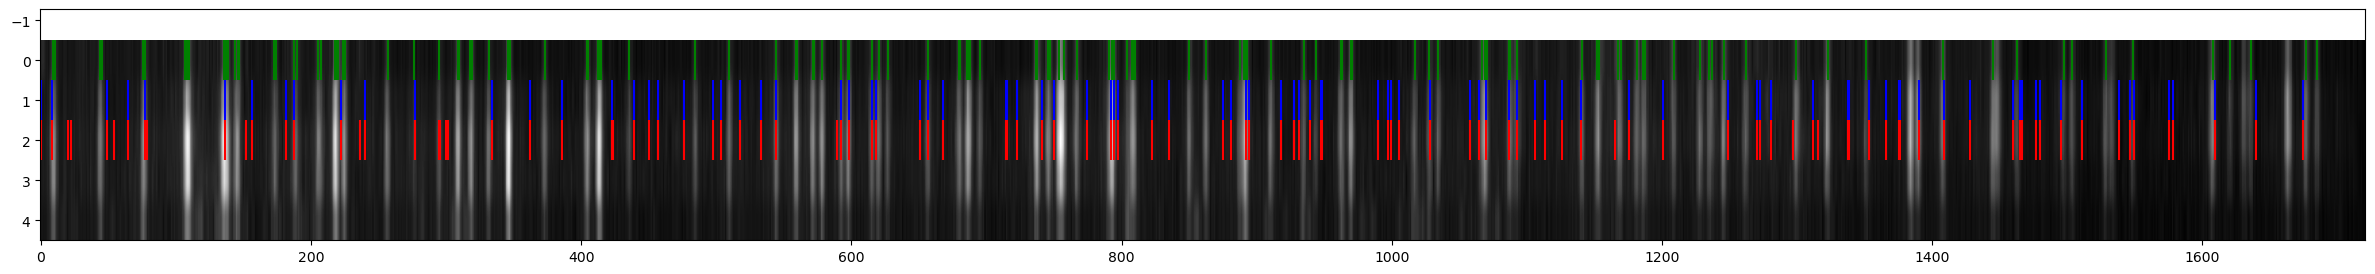

In [63]:
figure(figsize=(30, 3))
image_input = selector.selected[Molecule].bionano_image.segment_image[0]
target_width = localizer_module.image_channels
source_width = image_input.shape[0] // 2 + 1
image_input = image_input[source_width - target_width // 2: source_width + target_width // 2 + 1]
imshow(image_input, aspect="auto", cmap="gray")
eventplot([inference_item.loc_pred, x,y_hat], colors=["g", "b", "r"])
#xlim([0, 800])

In [64]:
from deepom.data_fetcher import DataFetcher

data_fetcher = DataFetcher(num_molecules=5)
# data_fetcher.generate_ground_truth_plots()
mol,a,b = data_fetcher.generate_ground_truth(molecule_index=0)
a,b

BasicUNet features: (32, 32, 64, 128, 256, 32).
loading checkpoint:  /home/deepom/DeepOM/data/pretrained/checkpoint.pickle 




selected: 0it [00:00, ?it/s]

/home/deepom/miniconda3/envs/deepom/lib/python3.9/site-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


(array([0, 0, 0, ..., 0, 0, 0]), array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]))

In [65]:
# import image module
from IPython.display import Image,display,plot_images
  
# get the image
for img_index in range(30):
    display(Image(url=f"../data/ground_truth/ground_truth_{img_index}.png"))
    
    

ImportError: cannot import name 'plot_images' from 'IPython.display' (/home/deepom/miniconda3/envs/deepom/lib/python3.9/site-packages/IPython/display.py)